# Aspect Based Sentiment Analysis on Zynga Poker Reviews

## Data Acquisition

We are extracting Bingo Pop review data from the [Google Play store](https://play.google.com/store/apps/details?id=com.zynga.livepoker&showAllReviews=true). We decided to focus primarily on the Google Play store as opposed to Apple App store because of the vast amount of ratings and reviews Google Play provided.

In [1]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 2.4MB/s 


### Import Libraries

In [162]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
from tqdm import tqdm

import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

import nltk
from nltk import FreqDist
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
app_packages = [
    'com.zynga.livepoker'
]

In [4]:
app_info = []

for game in tqdm(app_packages):
    info = app(game, lang = 'en', country = 'us')
    del info['comments']
    app_info.append(info)

100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Aids in highlighting important information in the JSON.

In [5]:
def print_json(json_object):
    json_str = json.dumps(
        json_object,
        indent = 2,
        sort_keys = True,
        default = str
    )

    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [6]:
print_json(app_info[0])

{
  "adSupported": true,
  "androidVersion": "4.1",
  "androidVersionText": "4.1 and up",
  "appId": "com.zynga.livepoker",
  "containsAds": true,
  "contentRating": "Teen",
  "contentRatingDescription": "Simulated Gambling",
  "currency": "USD",
  "description": "\ufeffJoin one of the world's most popular free poker games with more tables, more tournaments, more jackpots, and more players to challenge than ever before! Whether you prefer casual Texas Holdem Poker or competitive tournaments, Zynga Poker is your home for authentic gameplay.\r\n\r\n==ZYNGA POKER FEATURES==\r\n\r\nAUTHENTIC WORLD POKER TOUR EXPERIENCE \u2013 Play Holdem poker games like a pro at the WPT Final Table in the new WPT Tournament mode!\r\n\r\nHIGHER STAKES, BIGGER PAYOUTS \u2013 Higher buy-ins mean you can win even more virtual chips for every tournament you play.\r\n\r\nFASTER TOURNAMENTS \u2013 Compete at the traditional 9-person table or the new 5-person table for faster play.\r\n\r\nVIP PROGRAM \u2013 Earn 

In [7]:
app_info_df = pd.DataFrame(app_info)
app_info_df.head()

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,Zynga Poker – Free Texas Holdem Online Card Games,﻿Join one of the world's most popular free pok...,﻿Join one of the world&#39;s most popular free...,Be the stars. Play the most exciting series of...,Be the stars. Play the most exciting series of...,"50,000,000+",50000000,4.363787,2472750,709411,"[238262, 42106, 100989, 291847, 1799543]",0,True,USD,False,None,None,None,True,86M,4.1,4.1 and up,Zynga,6690081412016968981,android.support@zynga.com,https://www.zynga.com/,"699 8th Street, San Francisco. CA",https://www.zynga.com/privacy/policy,6690081412016968981,Casino,GAME_CASINO,https://lh3.googleusercontent.com/JYfNHIlJVGCn...,https://lh3.googleusercontent.com/-RCYQ1qcOmOi...,[https://lh3.googleusercontent.com/EOnSIIWRUUm...,None,None,Teen,Simulated Gambling,True,True,"Dec 21, 2010",1591909492,21.94,"More Rewards, More Challenges, More FREE CHIPS...","More Rewards, More Challenges, More FREE CHIPS...",com.zynga.livepoker,https://play.google.com/store/apps/details?id=...


In [8]:
app_info_df.to_csv('games.csv', index = None, header = True)

### Extract game reviews

We can filter by different ratings: 1 - 5 star. As well, we can sort reviews by most relevant, rating or newest. In this case, we will sort by the newest reviews to get an idea of what users are saying most recently and also will be able to see the change over time.

In [9]:
game_reviews = []

for game in tqdm(app_packages):
    for score in list(range(1, 6)):
        rvs, _ = reviews(
            game,
            lang = 'en',
            country = 'us',
            sort = Sort.NEWEST,
            count = 100000,
            filter_score_with = score
        )
        game_reviews.extend(rvs)

100%|██████████| 1/1 [05:44<00:00, 344.01s/it]


### Sample review

In [11]:
print_json(game_reviews[12])

{
  "at": "2020-06-21 17:57:26",
  "content": "Daily friend bonus doesn't work after the first month!! Seport doesn't see a problem after numerous screenshots and proof!! Very bad!!!",
  "repliedAt": "2020-03-02 06:17:11",
  "replyContent": "Hi Chrizandr\u0117, thank you for taking the time to leave us such a nice review. For gameplay concerns, you can reach out to us at http://zynga.my/ContactSupport Have a good day!",
  "reviewCreatedVersion": "21.89",
  "reviewId": "gp:AOqpTOFRzTVHsPuHG3FFpZDV2oDl-sjSnkW1588xFGfi1-1_SJ0je8uJwXu0TcbKtTjqhrk89hyv9NZ_ejR_Hw",
  "score": 1,
  "thumbsUpCount": 0,
  "userImage": "https://lh3.googleusercontent.com/-0C4hHe5AcB8/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucmFrxcXzaEdDHi9xEPTDXIuFczlWw/photo.jpg",
  "userName": "Chrizandr\u0117 Naude"
}



Key Information:
- `at` - Date & time a user left feedback
- `content` - Feedback given by the user
- `reviewCreatedVersion` - Current version of game
- `score` - Rating given be the user
- `thumbsUpCount` - Amount of people who also agreed with the review

In [12]:
game_reviews_df = pd.DataFrame(game_reviews)
game_reviews_df.shape

(197096, 10)

The Google Play store has approxiamately 2.5 million ratings and reviews. Of those reviews, 197,096 of them have feedback.

In [13]:
game_reviews_df['score'].value_counts(normalize=True)

5    0.507367
1    0.189547
4    0.179420
3    0.076308
2    0.047358
Name: score, dtype: float64

Majority of reviews - 50% are 5 star ratings.

### Save dataframe to CSV

In [14]:
game_reviews_df.to_csv('game_reviews.csv', index = None, header = True)

## Data Cleaning

In [136]:
clean_data_df = game_reviews_df[['at','content','score','thumbsUpCount','reviewCreatedVersion']]

In [137]:
clean_data_df.columns = ['date','review','rating','thumbs_up','version']

In [138]:
clean_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197096 entries, 0 to 197095
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       197096 non-null  datetime64[ns]
 1   review     196847 non-null  object        
 2   rating     197096 non-null  int64         
 3   thumbs_up  197096 non-null  int64         
 4   version    168724 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 7.5+ MB


There are 249(.001%) reviews with no text and 28372(14%) of the reviews do not have an associated version number.

In [139]:
# Drop the null reviews
clean_data_df = clean_data_df[~clean_data_df['review'].isna()]

In [140]:
clean_data_df.shape

(196847, 5)

In [141]:
# Function to plot the most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([str(text) for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns = 'count', n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x = 'word', y = 'count', palette = 'Blues_r')
    ax.set(ylabel = 'Count')
    plt.show()

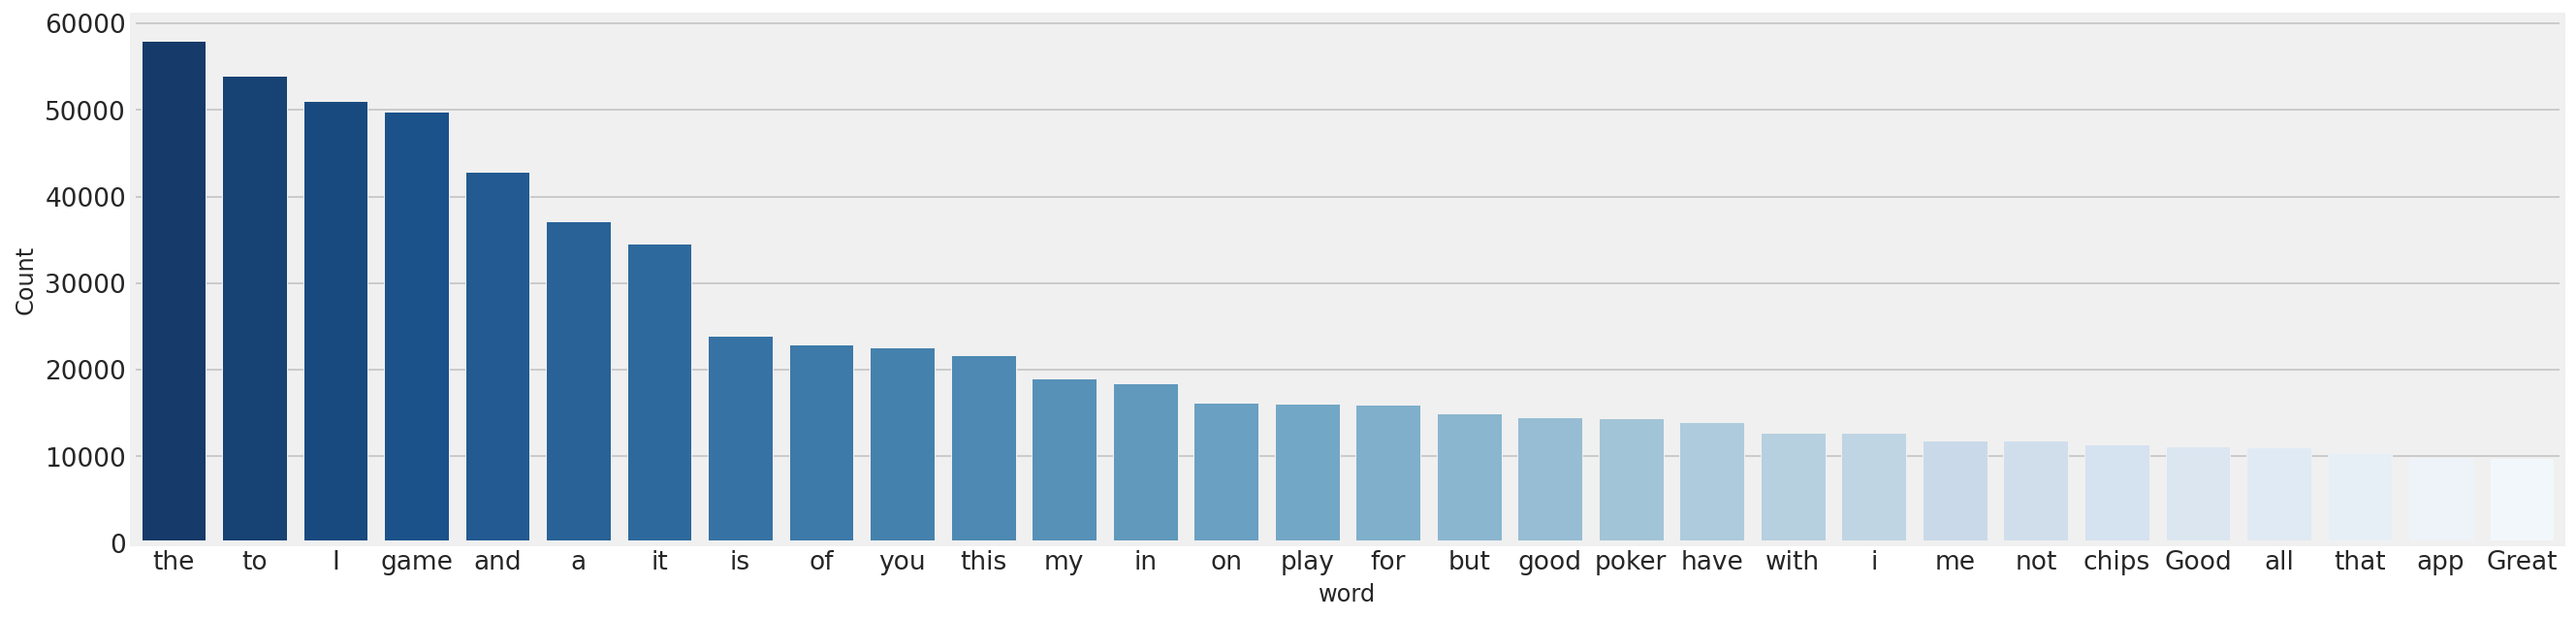

In [142]:
freq_words(clean_data_df['review'])

Common words such as: to, I, the, it are not important for our task. Thus, we will get rid of any unnecessary words.

In [143]:
#convert to lower case
clean_data_df['review'] = clean_data_df['review'].str.lower()

In [144]:
#url removal
clean_data_df['review'] = clean_data_df['review'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
clean_data_df['review'] = clean_data_df['review'].str.replace(r'www\.\S+\.com','')

In [145]:
#hashtags removal
clean_data_df['review'] = clean_data_df['review'].str.replace(r'#\S+', '')

In [146]:
#emoji removal
clean_data_df['review'] = clean_data_df['review'].str.replace(r'[^\x00-\x7F]+', '')

In [147]:
#html tag removal
clean_data_df['review'] = clean_data_df['review'].str.replace(r'<.*?>', '')

In [148]:
#removes extra spaces
clean_data_df['review'] = clean_data_df['review'].str.replace(r' +', ' ')

In [149]:
#punctuation removal
clean_data_df['review'] = clean_data_df['review'].str.replace('[{}]'.format(string.punctuation), '')

In [150]:
clean_data_df.head()

,date,review,rating,thumbs_up,version
0,2020-06-22 00:40:06,they have the antention to make you loose in o...,1,0,None
1,2020-06-22 00:02:06,zynga is rigged and only favors facebook players,1,0,21.94
2,2020-06-21 23:36:19,hopeless poker game restriction betting,1,0,21.94
3,2020-06-21 23:11:39,very bad after a few months playing they cut ...,1,0,21.94
4,2020-06-21 22:52:18,i tried a lot to log in but not responsed i l...,1,0,21.94


In [153]:
clean_data_df.head()


,date,review,rating,thumbs_up,version
0,2020-06-22 00:40:06,antention make loose order buy bad ecperince r...,1,0,None
1,2020-06-22 00:02:06,zynga rigged favors facebook players,1,0,21.94
2,2020-06-21 23:36:19,hopeless poker game restriction betting,1,0,21.94
3,2020-06-21 23:11:39,bad months playing cut stakes tables except 2 ...,1,0,21.94
4,2020-06-21 22:52:18,tried lot log responsed loged facebook 2010 wo...,1,0,21.94


In [151]:
# Function to remove stopwords
def remove_stopwords(rev):
    rev_new = ' '.join([i for i in rev if i not in stop_words])
    return rev_new

In [152]:
# Remove stopwords from the text
clean_data_df['review'] = [remove_stopwords(r.split()) for r in clean_data_df['review']]

In [134]:
#stop words removes
stop_words = stopwords.words('english')
clean_data_df['review'] = clean_data_df['review'].apply(lambda x: [item for item in x if item not in stop_words])

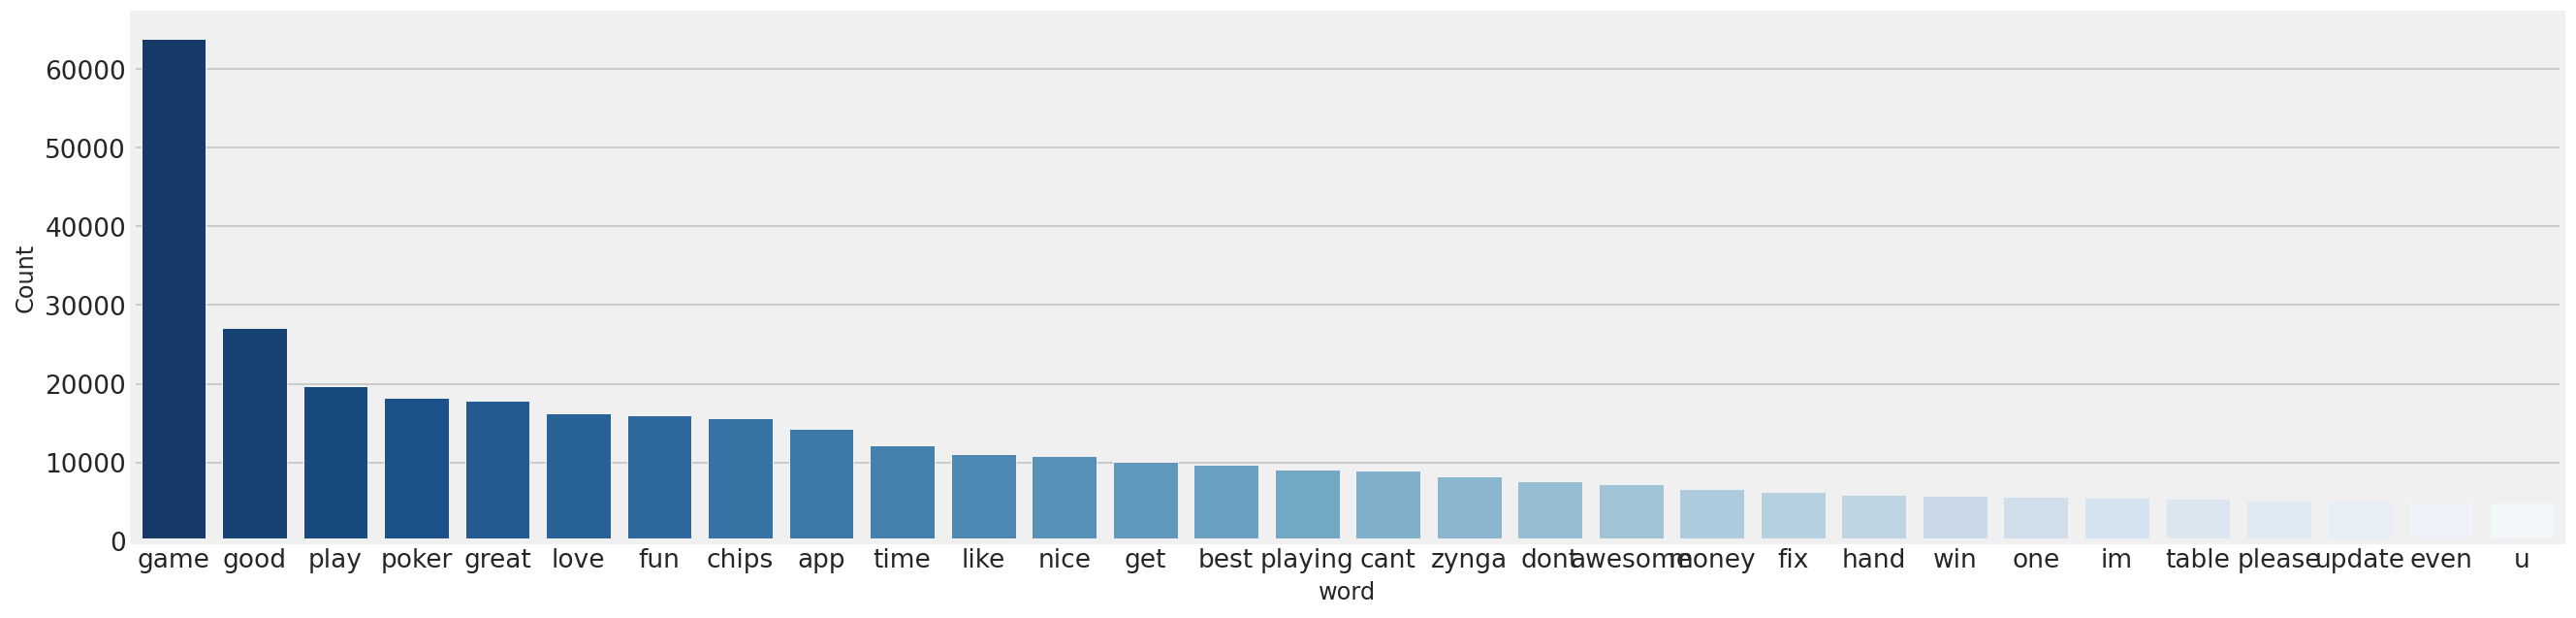

In [164]:
freq_words(clean_data_df['review'])

We now have more relevant terms we can use to build our model.